### Analyzing Used Car Listings on eBay Kleinanzeigen
In this Project we will try to analyze a dataset of used cars scraped from *eBay Kleinanzeigen*.

The data dictionary provided with data is as follows:
* dateCrawled - When this ad was first crawled. All field-values are taken from this date.
* name - Name of the car.
* seller - Whether the seller is private or a dealer.
* offerType - The type of listing
* price - The price on the ad to sell the car.
* abtest - Whether the listing is included in an A/B test.
* vehicleType - The vehicle Type.
* yearOfRegistration - The year in which the car was first registered.
* gearbox - The transmission type.
* powerPS - The power of the car in PS.
* model - The car model name.
* kilometer - How many kilometers the car has driven.
* monthOfRegistration - The month in which the car was first registered.
* fuelType - What type of fuel the car uses.
* brand - The brand of the car.
* notRepairedDamage - If the car has a damage which is not yet repaired.
* dateCreated - The date on which the eBay listing was created.
* nrOfPictures - The number of pictures in the ad.
* postalCode - The postal code for the location of the vehicle.
* lastSeenOnline - When the crawler saw this ad last online.

In [78]:
#Importing modules
%matplotlib inline 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [79]:
#Fixing the encoding error
autos = pd.read_csv("autos.csv", encoding="Latin-1")
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 20 columns):
dateCrawled            50000 non-null object
name                   50000 non-null object
seller                 50000 non-null object
offerType              50000 non-null object
price                  50000 non-null object
abtest                 50000 non-null object
vehicleType            44905 non-null object
yearOfRegistration     50000 non-null int64
gearbox                47320 non-null object
powerPS                50000 non-null int64
model                  47242 non-null object
odometer               50000 non-null object
monthOfRegistration    50000 non-null int64
fuelType               45518 non-null object
brand                  50000 non-null object
notRepairedDamage      40171 non-null object
dateCreated            50000 non-null object
nrOfPictures           50000 non-null int64
postalCode             50000 non-null int64
lastSeen               50000 non-null obj

The dataset contains 20 columns, most of which are strings. We have also data that ist stored as *strig* - columns "price" and "odometer"  but it should be *numeric*. The column names use camelcase instead of Python's preferred snakecase, which means we can't just replace spaces with underscores.

In [80]:
#Let's convert the column names from camelcase to snakecase and reword some of 
#the column names based on the data dictionary to be more descriptive.
autos.rename(columns={"dateCrawled": "date_crawled",
              "offerType": "offer_type",
              "vehicleType": "vehicle_type",
              "yearOfRegistration": "registration_year",
              "powerPS": "power_ps",
              "fuelType": "fuel_type",
              "monthOfRegistration": "registration_month",
              "notRepairedDamage": "unrepaired_damage",
              "dateCreated": "ad_created",
              "odometer": "odometer_km",
              "lastSeen": "last_seen",
              "nrOfPictures": "num_photos"
             }, inplace=True)

In [81]:
#Fixing dtype errors
autos["odometer_km"] = autos["odometer_km"].str.replace(",", "")
autos["odometer_km"] = autos["odometer_km"].str.replace("km", "").astype(int) 

autos["price"] = autos["price"].str.replace(",", "")
autos["price"] = autos["price"].str.replace("$", "").astype(int)

There are three columns without usefull information because they contain values that are not unique, we will delete these columns from our data.

In [82]:
autos.seller.value_counts()

privat        49999
gewerblich        1
Name: seller, dtype: int64

In [83]:
autos = autos.drop(["num_photos", "seller", "offer_type"], axis=1)

There are some important features like mileage, year and brand, that significantly influence the price, we will try to analyze them.

In [116]:
#Let's start with the "price" column
autos.price.describe()
autos.price.value_counts().sort_index(ascending=False).head(5)

80000    2
79999    1
79980    1
79933    1
79500    1
Name: price, dtype: int64

The prices 100 000 000 and 0 are not very realistic. The *price* column seems to contain outliers that should be removed. We will do the same thing for the 'year' column because we are not interested in a car that is an Oldtimer.

In [86]:
autos = autos[autos["price"].between(500, 80000)]
autos = autos[autos["registration_year"].between(1990, 2016)]

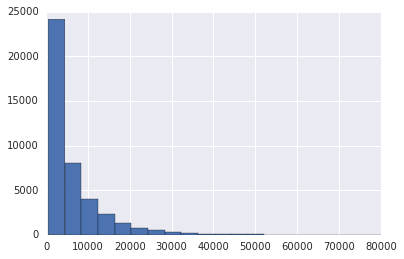

In [117]:
fig, ax = plt.subplots()

ax.hist(autos["price"], bins=20, range=(500, 80000))
plt.show()

It seems that the most of the offers are in the 500-20000$ range.

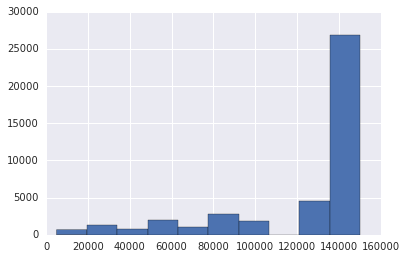

In [118]:
fig, ax = plt.subplots()
ax.hist(autos['odometer_km'])
plt.show()

There are more vehicles with the mileage between 120,000 and 140,000 km than low mileage ones. NUsually a car travels on average 10000km per year. Let's see what is happening in the year's column and to search for a relationship between the year and the mileage.

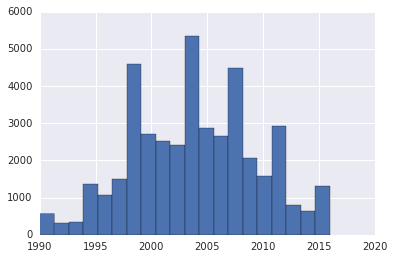

In [119]:
fig, ax = plt.subplots()
ax.hist(autos['registration_year'], bins=20)
plt.show()

The data was scrapped in 2016 and as we can see the most of the vehicles are already 8 -11 year old. So if we need a new car maybe it will be better to visit a showroom.

/dataquest/system/env/python3/lib/python3.4/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


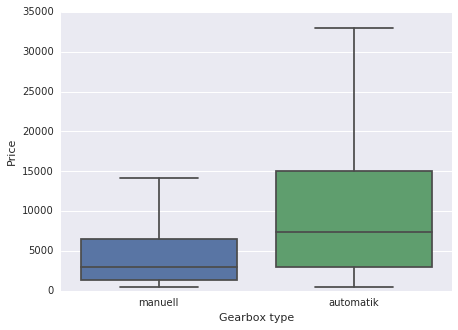

In [120]:
fig, ax = plt.subplots(figsize=(7,5))
ax = sns.boxplot(x="gearbox", y="price", data=autos, showfliers=False)
ax.set_ylabel('Price')
ax.set_xlabel('Gearbox type')
plt.show()

If we want a cheaper car we have to think definitively of one with manual gearbox.

/dataquest/system/env/python3/lib/python3.4/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


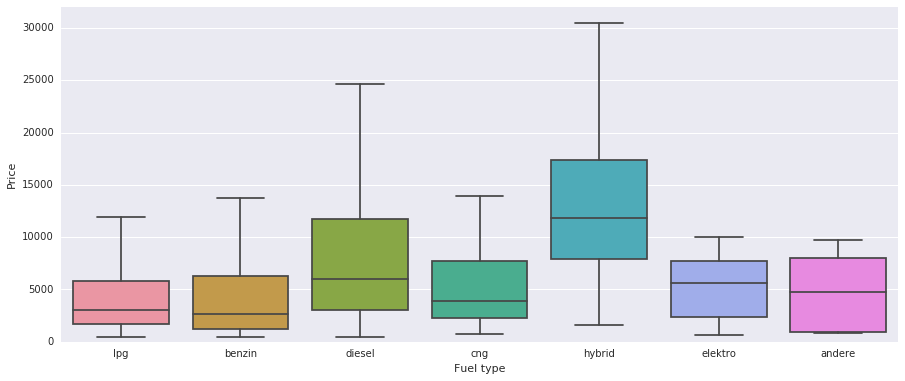

In [121]:
fig, ax = plt.subplots(figsize=(15,6))
ax = sns.boxplot(x="fuel_type", y="price", data=autos, showfliers=False)
ax.set_ylabel('Price')
ax.set_xlabel('Fuel type')
ax.set_ylim(0,32000)

plt.show()

Yes, trying to save the world and the enviroment it is not cheap at all. We will try to look further for the most popular brands on the market.

In [90]:
#Let us select the top six most popular brand on the market
top_six_brands = autos["brand"].value_counts().head(6)

In [91]:
# We will calculate the mean price for each brand 
brands = top_six_brands.index

brands_mean_prices = {}

for brand in brands:
    selected_rows = autos[autos['brand'] == brand]
    mean = selected_rows["price"].mean()
    brands_mean_prices[brand] = int(mean)  

#And also the mean mileage
brands_mean_mileage = {}

for brand in brands:
    selected_rows = autos[autos['brand'] == brand]
    mean = selected_rows["odometer_km"].mean()
    brands_mean_mileage[brand] = int(mean) 

    
#At the end we will create an agregate dataframe
bmp_series = pd.Series(brands_mean_prices)
bmp_series = bmp_series.sort_values(ascending=False)
bmm_series = pd.Series(brands_mean_mileage)

df_mean = pd.DataFrame(bmp_series, columns=['mean_price'])
df_mean['mean_mileage'] = bmm_series

df_mean

,mean_price,mean_mileage
audi,9643,128749
mercedes_benz,8574,131147
bmw,8478,133031
volkswagen,5780,128617
ford,3950,124620
opel,3374,128637


Of the top 6 brands, there is a distinct price gap. We can notice that Audi, Mercedes and BMW are almost 50% expensiver as the Volkswagen, Ford and Opel even if there isn't a big difference in the mileage. 

### Conclusion

If we want to a by a car on the German market we should decide how big is our budget. The eBay Klein Anzeige is a good place if we want ot buy a good used German car with the mileage above 120000 km and for a fair price. Depending on the gearbox type and the type of fuel, the price varies significantly. You should be ready to pay more for brands like Audi and Mercedes, but if you need a family car I recommend you a Volkswagen.  